# Analysis of career transition options for high-risk occupations

This notebook reproduces the analyses in Part B of the Mapping Career Causeways report, where we explore the career transition options for workers in high-risk occupations.


# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble_Transitions.ipy
import os
from scipy.stats import ks_2samp, mannwhitneyu, spearmanr, kruskal, linregress
import mapping_career_causeways.plotting_utils as plot_utils
import plotly.graph_objects as go
data = load_data.Data()

In [2]:
# True if need to export plots 
produce_plots = False

In [3]:
# Import data on transitions
occ_transitions = pd.read_csv(data_folder + 'processed/transitions/ESCO_number_of_transitions.csv')

occ_transitions = data.add_field_to_occupation(occ_transitions, field_name='level_1')
occ_transitions = data.add_field_to_occupation(occ_transitions, field_name='skills_based_sector')
occ_transitions = data.add_field_to_occupation(occ_transitions, field_name='level_2')
occ_transitions = data.add_field_to_occupation(occ_transitions, field_name='sub_sector')

occ_high = occ_transitions[occ_transitions.risk_category=='High risk']
occ_lower = occ_transitions[occ_transitions.risk_category=='Lower risk']

In [4]:
# All transitions above the minimal similarity threshold
trans = trans_utils.get_transitions(origin_ids='report', destination_ids='report', verbose=True)

# Add fields to the transition dataframe
for field in ['risk', 'prevalence', 'exposure_score']:
    trans = data.add_field_to_occupation(trans, 'origin_id', field, 'origin')
    trans = data.add_field_to_occupation(trans, 'destination_id', field, 'destination')

Finding all transitions... Done!
This took 20.44 seconds.


In [5]:
occ_transitions.head(2)

id                                        concept_uri  \
0   1  http://data.europa.eu/esco/occupation/000e93a3...   
1   3  http://data.europa.eu/esco/occupation/0022f466...   

                  preferred_label  isco_level_4 risk_category  n_desirable  \
0  metal drawing machine operator          8121    Lower risk          142   
1   air traffic safety technician          3155    Lower risk           27   

   n_desirable_and_highly_viable  n_safe_desirable  \
0                            103               142   
1                              1                27   

   n_safe_desirable_and_highly_viable  n_safe_desirable_strict  \
0                                 103                        2   
1                                   1                       10   

   n_safe_desirable_strict_and_highly_viable  level_1  \
0                                          0        3   
1                                          0        0   

                                 skills_based_sector  level_2  \
0                              manufacturing workers       16   
1  technicians, construction, transport & securit...        3   

                          sub_sector  
0  metal workers & machine operators  
1       transport & security workers

In [6]:
trans.sample(3)

origin_id                origin_label  destination_id  \
45214       1420   Montessori school teacher            1559   
55990       1726  starch extraction operator            1509   
8643         286                    solderer             895   

                    destination_label  similarity  is_jobzone_ok  \
45214              vocational teacher    0.698161           True   
55990  beverage filtration technician    0.551287           True   
8643     cylindrical grinder operator    0.542459           True   

       is_earnings_ok  is_not_high_risk  is_safer  is_strictly_safe  ...  \
45214            True              True     False             False  ...   
55990            True              True     False             False  ...   
8643             True              True     False             False  ...   

       is_viable  is_desirable  is_safe_desirable  is_strictly_safe_desirable  \
45214       True          True               True                       False   
55990       True          True               True                       False   
8643        True          True               True                       False   

       origin_risk  destination_risk  origin_prevalence  \
45214     3.458337          3.567191           0.578507   
55990     3.459233          3.459233           0.817627   
8643      3.458144          3.490060           0.789764   

       destination_prevalence  origin_exposure_score  \
45214                0.494617               0.571652   
55990                0.817627               0.672583   
8643                 0.452652               0.665980   

       destination_exposure_score  
45214                    0.449444  
55990                    0.672583  
8643                     0.688840  

[3 rows x 31 columns]

## 0.1 Helper functions

In [7]:
def get_difference(df, col='n_desirable'):
    """ 
    Calculates percentage difference of the number of transitions
    between Lower Risk and High Risk occupations
    """
    p_dif = (df.loc['Lower risk', col] - df.loc['High risk', col]) / (df.loc['Lower risk', col])
    if (p_dif > 0):
        dif='fewer'
    else:
        dif='more'        
    print(f'High risk occupations have {np.round(p_dif * 100)}% {dif} {col} than Lower risk occupations')
    return p_dif

def test_dif(col='n_desirable'):
    """ Checks if difference in medians is statistically significant """
    k = kruskal(occ_high[col], occ_lower[col])
    print(f'Population medians are different with p-value {k.pvalue:.5f} (Kruskal–Wallis test)')
    return k

def test_corr(df, x, y):
    """ Tests correlations """
    return spearmanr(df[x], df[y])

def add_risk_category(df, col='origin_id', prefix='origin'):
    """ Adds occupation's risk category to the dataframe """
    return df.merge(occ_transitions[['id', 'risk_category']], left_on=col, right_on='id').rename(columns={'risk_category': f'{prefix}_risk_category'}).drop('id', axis=1)

def get_mean_destinations(trans):
    """
    Calculates average statistics across occupations' destinations
    """
    mean_destination = trans.groupby('origin_id').agg({
        'similarity':'mean',
        'destination_risk': 'mean',
        'destination_prevalence': 'mean'}).reset_index()
    mean_destination = data.add_field_to_occupation(mean_destination, 'origin_id', 'risk', 'origin')
    mean_destination = data.add_field_to_occupation(mean_destination, 'origin_id', 'prevalence', 'origin')
    mean_destination = add_risk_category(mean_destination, 'origin_id', 'origin')
    return mean_destination

def check_dif(job_zone_i=2, job_zone_j=3):
    """
    Checks if difference in the number of transitions for occupations
    in different job zones is statistically significant
    """
    return kruskal(
        df[df.job_zone==job_zone_i].n_safe_desirable_strict.to_list(),
        df[df.job_zone==job_zone_j].n_safe_desirable_strict.to_list())    

# 1. Number of desirable transitions

When a worker is moving jobs, they will first consider those
occupations that require similar skills to their current job;
we call such transitions ‘viable’. Moreover, only a subset
of the viable transitions will also be ‘desirable’ in that
they will enable the worker to sustain a similar or higher
standard of living. We found that workers in high-risk
occupations have on average 26 per cent fewer desirable
transitions compared to workers in lower-risk occupations

## 1.1 Mean and median desirable transitions

In [8]:
# Mean
desirable_mean = occ_transitions.groupby('risk_category').agg({'n_desirable': 'mean'}).round(2)
desirable_mean

n_desirable
risk_category             
High risk            33.85
Lower risk           46.04

In [9]:
get_difference(desirable_mean.round())

High risk occupations have 26.0% fewer n_desirable than Lower risk occupations


0.2608695652173913

In [10]:
# Median
desirable_median = occ_transitions.groupby('risk_category').agg({'n_desirable': 'median'}).round(2)
desirable_median

n_desirable
risk_category             
High risk               27
Lower risk              30

In [11]:
get_difference(desirable_median)

High risk occupations have 10.0% fewer n_desirable than Lower risk occupations


0.1

In [12]:
test_dif('n_desirable').pvalue

Population medians are different with p-value 0.01569 (Kruskal–Wallis test)


0.015694848740426145

### Barplots showing desirable transitions

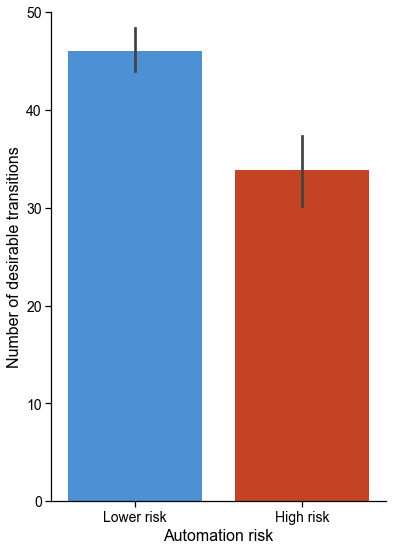

In [13]:
plt.figure(figsize=(6,9))
barlist=sns.barplot(
    data=occ_transitions,
    x='risk_category', 
    y="n_desirable",
    palette= [plot_utils.colour_map['Low risk'], plot_utils.colour_map['High risk']])

plt.ylabel('Number of desirable transitions', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('Automation risk', fontsize=16)
plt.xticks([0,1], ['Lower risk', 'High risk'], fontsize=14)
plt.ylim([0, 50])
plot_utils.remove_right_axis(barlist)
if produce_plots: plot_utils.export_figure('fig_30')
plt.show()


### Drivers of group differences

This difference is primarily driven by select groups
of lower-risk occupations that have a high number
of desirable transition options, namely jobs in
manufacturing and food and tobacco production.

In [14]:
df_viz = occ_transitions.copy()
df_viz['coloring'] = 'other'
df_viz.loc[df_viz.level_1==3 ,'coloring'] = 'manufacturing'
df_viz.loc[df_viz.level_1==8 ,'coloring'] = 'food & tobbacco production'
df_viz.loc[df_viz.level_1==2 ,'coloring'] = 'sales & services'

colour_map = {
    'manufacturing': plot_utils.colour_pal[3],
    'food & tobbacco production': plot_utils.colour_pal[0],
    'sales & services': plot_utils.colour_pal[2],
    'other': [0.8, 0.8, 0.8]
}

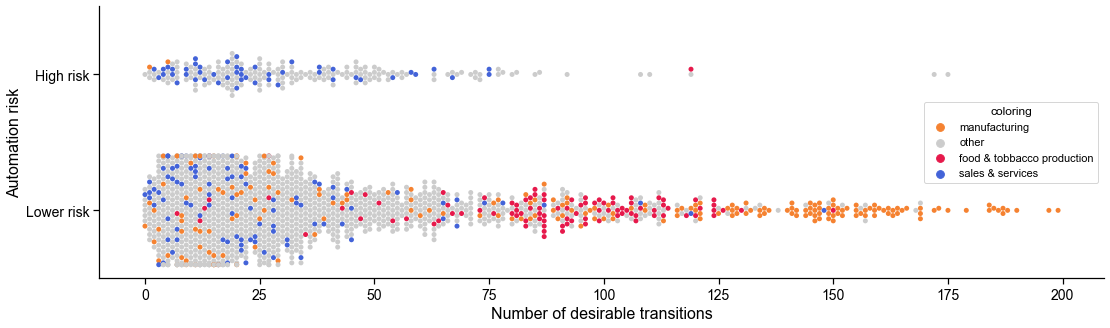

In [15]:
plt.figure(figsize=(18,5))
ax = sns.swarmplot(
    data=df_viz,
    y='risk_category', 
    x="n_desirable",
    hue='coloring',
    palette = colour_map,
    order = ['High risk', 'Lower risk']
)
plt.xlabel('Number of desirable transitions', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Automation risk', fontsize=16)
plt.yticks(fontsize=14)
plot_utils.remove_right_axis(ax)
if produce_plots: plot_utils.export_figure('fig_31')


## 1.2 Relationship between origin and their average destination occupations

Both automation risk and the shortage of bottleneck tasks
are strongly localised, and ‘neighbouring’ occupations
– which are likely to be each other’s viable transition
destinations – have similar exposure to automation.
Indeed, the automation exposure of a worker’s current
occupation and their desirable destinations is strongly
correlated.

In [16]:
mean_destination = get_mean_destinations(trans[trans['is_desirable']])
mean_destination.sample(3)

origin_id  similarity  destination_risk  destination_prevalence  \
243         435    0.339332          3.449659                0.795691   
257         457    0.359622          3.465467                0.735556   
1424       2564    0.321706          3.650030                0.480046   

      origin_risk  origin_prevalence origin_risk_category  
243      3.295883           0.831651           Lower risk  
257      3.547436           0.656525           Lower risk  
1424     3.618612           0.517658           Lower risk

### Origin and average destination risk

In [17]:
test_corr(mean_destination, 'origin_risk', 'destination_risk')

SpearmanrResult(correlation=0.5449485689685355, pvalue=8.242678251618051e-126)

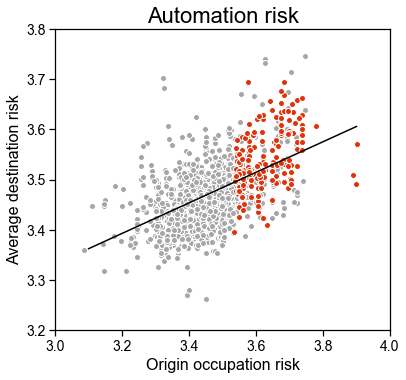

In [18]:
plt.figure(figsize=(6,6))

# Linear regression model
lin_coef = linregress(mean_destination.origin_risk, mean_destination.destination_risk)
x_vals = [3.1, 3.9]
y_lin = [lin_coef.slope*x+lin_coef.intercept for x in x_vals]

ax = plt.scatter(
    x=mean_destination[mean_destination.origin_risk_category!='High risk'].origin_risk,
    y=mean_destination[mean_destination.origin_risk_category!='High risk'].destination_risk,
    alpha=1, edgecolors=[1,1,1],
    color=(0.65,.65,.65)
)
ax = plt.scatter(
    x=mean_destination[mean_destination.origin_risk_category=='High risk'].origin_risk,
    y=mean_destination[mean_destination.origin_risk_category=='High risk'].destination_risk,
    alpha=1, edgecolors=[1,1,1],
    color = plot_utils.colour_map['High risk']
)

plt.plot(x_vals, y_lin, color='k', linewidth=1.5)

ax.axes.set_aspect(1.5)
plt.xlim([3, 4])
plt.ylim([3.2, 3.8])
plt.xlabel('Origin occupation risk', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Average destination risk', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Automation risk', fontsize=22)
if produce_plots: plot_utils.export_figure('fig_33')
plt.show()


### Origin and average destination prevalence

In [19]:
test_corr(mean_destination, 'origin_prevalence', 'destination_prevalence')

SpearmanrResult(correlation=0.80374246471072, pvalue=0.0)

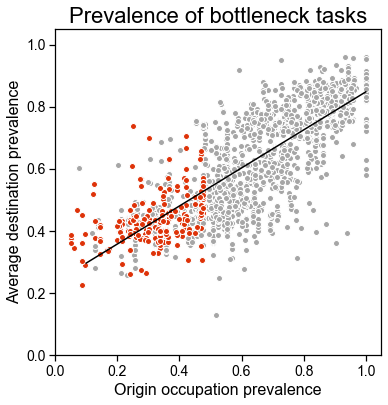

In [20]:
plt.figure(figsize=(6,6))

lin_coef = linregress(mean_destination.origin_prevalence, mean_destination.destination_prevalence)
x_vals = [0.1, 1]
y_lin = [lin_coef.slope*x+lin_coef.intercept for x in x_vals]

ax = plt.scatter(
    x=mean_destination[mean_destination.origin_risk_category!='High risk'].origin_prevalence,
    y=mean_destination[mean_destination.origin_risk_category!='High risk'].destination_prevalence,
    alpha=1,edgecolors=[1,1,1],
    color=(0.65,.65,.65))

ax = plt.scatter(
    x=mean_destination[mean_destination.origin_risk_category=='High risk'].origin_prevalence,
    y=mean_destination[mean_destination.origin_risk_category=='High risk'].destination_prevalence,
    alpha=1, edgecolors=[1,1,1],
    color = plot_utils.colour_map['High risk'])

plt.plot(x_vals, y_lin, color='k', linewidth=1.5)

ax.axes.set_aspect(1)
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])

plt.xlabel('Origin occupation prevalence', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Average destination prevalence', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Prevalence of bottleneck tasks', fontsize=22)
if produce_plots: plot_utils.export_figure('fig_33_prevalence')
plt.show()


### Destination risk categories for transitions out of high-risk occupations

Approximately
one-third of all desirable transitions and half of highly
viable and desirable transitions originating from high-risk
occupations end up in other high-risk occupations.

In [21]:
# Fraction of desirable transition destinations that are not high risk
trans_high_risk = trans[trans.origin_id.isin(data.occ_report[data.occ_report.risk_category=='High risk'].id.to_list())].copy()
df = trans_high_risk[trans_high_risk.is_desirable].groupby('is_not_high_risk').agg({'destination_id': 'count'})
df = df/df.sum()
df


destination_id
is_not_high_risk                
False                   0.345269
True                    0.654731

In [22]:
# Fraction of highly viable, desirable transition destinations that are not high risk
df = trans_high_risk[trans_high_risk.is_desirable
                    & (trans_high_risk['sim_category'] == 'highly_viable')].groupby('is_not_high_risk').agg({'destination_id': 'count'})
df = df/df.sum()
df

destination_id
is_not_high_risk                
False                   0.457481
True                    0.542519

Strikingly, one-third of high-risk occupations have no highly
viable pathways to occupations in a lower-risk category
– these include predominantly clerical support workers,
such as transport and numerical clerks, and business and
administration workers (e.g. accounting assistants and
middle office analysts)

In [23]:
# High risk occupations without highly viable transitions to 'lower risk' destinations
df = occ_high[occ_high.n_safe_desirable_and_highly_viable==0]
len(df) / len(occ_high)

0.2995391705069124

In [24]:
# ISCO major groups of such occupations
data.add_field_to_occupation(
    df, field_name='isco_level_1'
).groupby('isco_level_1').agg({'id': 'count'}).reset_index().merge(
    data.isco_titles, left_on='isco_level_1', right_on='isco', how='left'
).drop(['isco', 'level'], axis=1).sort_values('id', ascending=False).rename(columns={'id': 'counts'})


isco_level_1  counts                                   isco_title
3             4      25                     Clerical support workers
1             2      16                                Professionals
2             3       9      Technicians and associate professionals
4             5       6                    Service and sales workers
6             9       4                       Elementary occupations
0             1       3                                     Managers
5             8       2  Plant and machine operators, and assemblers

In [25]:
# Skills-based sectors of such occupations
df.groupby('skills_based_sector').agg(
    {'id': 'count'}
).reset_index().sort_values('id', ascending=False).rename(columns={'id': 'counts'}).head(5)


skills_based_sector  counts
1  business & administration workers      31
7           sales & services workers      18
0               arts & media workers       4
8                     social workers       3
4                        ict workers       2

# 2. Safe and desirable transitions

The distribution of automation risk across occupations
exacerbates the disparity between high-risk and lower-risk
jobs. While the high-risk occupations have 26 per cent
less, on average, desirable transitions than lower-risk
occupations, the difference increases to 49 per cent
when we rule out transitions that would push the worker
into another high-risk occupation.

## 2.1 Mean and median safe and desirable transitions

In [26]:
# Mean
desirable_mean = occ_transitions.groupby('risk_category').agg({'n_safe_desirable': 'mean'}).round(2)
desirable_mean

n_safe_desirable
risk_category                  
High risk                 22.16
Lower risk                42.78

In [27]:
get_difference(desirable_mean.round(), 'n_safe_desirable')

High risk occupations have 49.0% fewer n_safe_desirable than Lower risk occupations


0.4883720930232558

In [28]:
# Median
desirable_median = occ_transitions.groupby('risk_category').agg({'n_safe_desirable': 'median'}).round(2)
desirable_median

n_safe_desirable
risk_category                  
High risk                    15
Lower risk                   26

In [29]:
get_difference(desirable_median, 'n_safe_desirable')

High risk occupations have 42.0% fewer n_safe_desirable than Lower risk occupations


0.4230769230769231

In [30]:
test_dif('n_safe_desirable').pvalue

Population medians are different with p-value 0.00000 (Kruskal–Wallis test)


1.0457815050107155e-13

### Barplots showing safe and desirable transitions

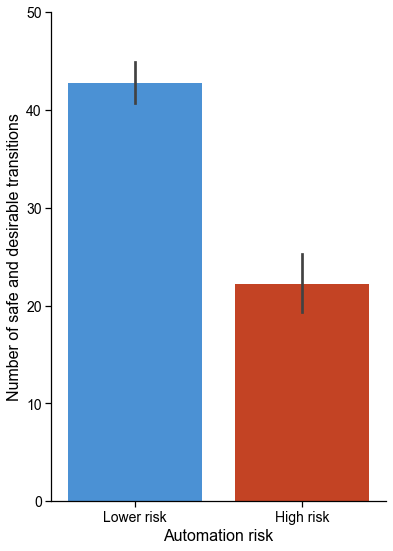

In [31]:
plt.figure(figsize=(6,9))
barlist=sns.barplot(
    data=occ_transitions,
    x='risk_category', 
    y="n_safe_desirable",
    palette= [plot_utils.colour_map['Low risk'], plot_utils.colour_map['High risk']])

plt.ylabel('Number of safe and desirable transitions', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel('Automation risk', fontsize=16)
plt.xticks([0,1], ['Lower risk', 'High risk'], fontsize=14)
plt.ylim([0, 50])
plot_utils.remove_right_axis(barlist)
if produce_plots: plot_utils.export_figure('fig_35')
plt.show()


## 2.2 Similarities to average safe and desirable occupations

In [32]:
mean_destination = get_mean_destinations(trans[trans['is_safe_desirable']])
mean_destination.sample(3)

origin_id  similarity  destination_risk  destination_prevalence  \
1380       2490    0.348321          3.452756                0.503113   
951        1715    0.350449          3.473653                0.784545   
630        1159    0.392133          3.444704                0.431774   

      origin_risk  origin_prevalence origin_risk_category  
1380     3.703095           0.259536            High risk  
951      3.549294           0.540367           Lower risk  
630      3.562178           0.050737            High risk

/Users/karliskanders/opt/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/seaborn/relational.py:818: MatplotlibDeprecationWarning:

Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.

/Users/karliskanders/opt/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/seaborn/relational.py:829: MatplotlibDeprecationWarning:

Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.



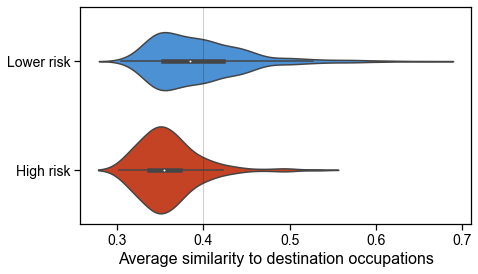

In [33]:
plt.figure(figsize=(7,4))
sns.violinplot(
    data=mean_destination,
    y='origin_risk_category', x='similarity', 
    palette= [
        plot_utils.colour_map['High risk'],
        plot_utils.colour_map['Low risk']],
    order=['High risk', 'Lower risk'])
sns.lineplot(x=[0.4,0.4], y=[-2, 2], linewidth=1, c='k')
plt.ylabel('', fontsize=16)
plt.xlabel('Average similarity to destination occupations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([-0.5, 1.5])
if produce_plots: plot_utils.export_figure('fig_37')
plt.show()

In [34]:
# Check if distributions are sufficiently different
ks_2samp(
    mean_destination[mean_destination.origin_risk_category=='High risk'].similarity,
    mean_destination[mean_destination.origin_risk_category=='Lower risk'].similarity
)

Ks_2sampResult(statistic=0.3322723778440126, pvalue=4.429049538545435e-18)

In [35]:
# Check if distributions are sufficiently different
mannwhitneyu(
    mean_destination[mean_destination.origin_risk_category=='High risk'].similarity,
    mean_destination[mean_destination.origin_risk_category=='Lower risk'].similarity
)

MannwhitneyuResult(statistic=86859.0, pvalue=1.0910649604793675e-22)

# 3. Safe and desirable transitions (stricter condition)

### Transition matrix between skills-based sectors

In [36]:
# Prepare a dataframe with high risk occupation transition origins and destinations,
# and their corresponding level_1 clusters (skills-based sectors)
df = trans_high_risk[trans_high_risk.is_strictly_safe_desirable]
df = data.add_field_to_occupation(df, 'origin_id', 'level_1', 'origin')
df = data.add_field_to_occupation(df, 'destination_id', 'level_1', 'destination')
# ..and corresponding level_2 clusters (skills-based sub-sectors)
df = data.add_field_to_occupation(df, 'origin_id', 'level_2', 'origin')
df = data.add_field_to_occupation(df, 'destination_id', 'level_2', 'destination')
print(len(df))
df.head(1)

3619


origin_id    origin_label  destination_id       destination_label  \
0         29  legal guardian            2867  recreational therapist   

   similarity  is_jobzone_ok  is_earnings_ok  is_not_high_risk  is_safer  \
0     0.37022           True            True              True      True   

   is_strictly_safe  ...  origin_risk  destination_risk  origin_prevalence  \
0              True  ...     3.539648          3.261842           0.336794   

   destination_prevalence  origin_exposure_score  destination_exposure_score  \
0                0.558333               0.551222                    0.675883   

   origin_level_1  destination_level_1  origin_level_2  destination_level_2  
0              13                   10              52                   41  

[1 rows x 35 columns]

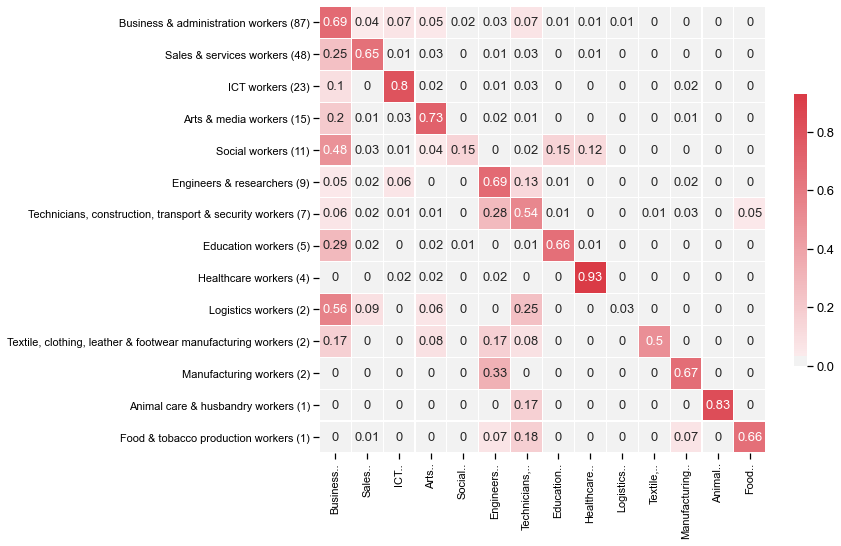

In [37]:
# Calculate the transition flow matrix
level = 'level_1'
flow_matrix_lvl1 = trans_utils.get_flow_matrix(df, level)
flow_matrix_lvl1_norm = trans_utils.normalise_rows(flow_matrix_lvl1)

# Organise matrix's rows according to the number of occupations in each sector
high_risk_counts_level_1 = data.occ_report[data.occ_report.risk_category=='High risk'].groupby(
    'level_1').agg({'id': 'count'}).id.to_list()
ordering_lvl1_by_N = list(np.flip(np.argsort(high_risk_counts_level_1)))                                    
labels_lvl1 = data.clusters_level_1.manual_labels.to_list()
for x in range(len(labels_lvl1)):
    labels_lvl1[x] = labels_lvl1[x].capitalize()
labels_lvl1[-3] = 'ICT workers'
y_labels_lvl1 = [labels_lvl1[x] + f" ({high_risk_counts_level_1[x]})" for x in range(len(labels_lvl1))]

# Plot the heatmap
ax = plot_utils.plot_heatmap(np.round(flow_matrix_lvl1_norm, 2), labels_lvl1, y_labels_lvl1, new_order=ordering_lvl1_by_N)
ax.tick_params(axis='both', which='major', labelsize=11)
if produce_plots: plot_utils.export_figure('fig_36')
plt.show()


Numbers indicate the fraction of safe and desirable transitions originating from high-risk occupations within a sector (rows)
and terminating in lower-risk occupations (columns). Each row sums to 1. The numbers in brackets indicate the number of high-risk
occupations within that skills-based sector.

/Users/karliskanders/Documents/mapping-career-causeways/mapping_career_causeways/transitions_utils.py:1246: RuntimeWarning:

invalid value encountered in true_divide



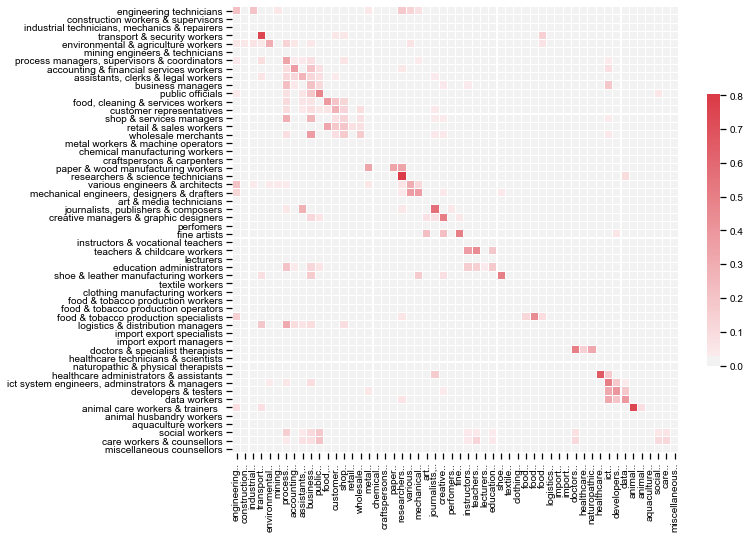

In [38]:
# Non-normalised matrix between skills-based sub-sectors
flow_matrix_lvl2_norm = trans_utils.normalise_rows(trans_utils.get_flow_matrix(df, 'level_2'))
flow_matrix_lvl2_norm[np.isnan(flow_matrix_lvl2_norm)] = 0
labels_lvl2 = data.clusters_level_2.manual_labels.to_list()
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plot_utils.plot_heatmap(
    flow_matrix_lvl2_norm, labels_lvl2, labels_lvl2, annot=False)
plot_utils.set_font_sizes()

### High-risk occupations with most and least transitions

In [39]:
# Highest number of transitions
occ_high.sort_values('n_safe_desirable_strict', ascending=False)[[
    'id', 'preferred_label', 'isco_level_4', 'n_safe_desirable_strict']].head(21)


id                   preferred_label  isco_level_4  \
346    625                      food analyst          3111   
1596  2879     child day care centre manager          1341   
1069  1907        corporate training manager          2424   
641   1166   maintenance and repair engineer          2141   
547   1002               industrial engineer          2141   
341    615                    credit manager          3312   
18      33            tour operators manager          3339   
671   1223  employment programme coordinator          2422   
332    596                 financial manager          1211   
494    889                     social worker          2635   
557   1028            pipeline route manager          4323   
1473  2638                     asset manager          3311   
222    399          labour relations officer          2423   
1465  2627                       headteacher          1345   
1547  2770            ICT operations manager          1330   
312    555          academic support officer          2359   
1194  2124               credit risk analyst          3312   
549   1010                specialised seller          5223   
580   1067          insurance agency manager          1346   
1169  2083                      risk manager          2412   
91     160           ICT security consultant          2529   

      n_safe_desirable_strict  
346                       109  
1596                       83  
1069                       74  
641                        73  
547                        65  
341                        59  
18                         54  
671                        54  
332                        49  
494                        47  
557                        44  
1473                       42  
222                        40  
1465                       40  
1547                       39  
312                        38  
1194                       37  
549                        37  
580                        37  
1169                       37  
91                         37

In [40]:
# Lowest number of transitions
occ_high.sort_values('n_safe_desirable_strict', ascending=True)[[
    'id', 'preferred_label', 'isco_level_4', 'n_safe_desirable_strict']].head(21)


id                     preferred_label  isco_level_4  \
1151  2054                       payroll clerk          4313   
1477  2645  amusement and recreation attendant          9629   
906   1627                human rights officer          2619   
941   1689                    tourist animator          2659   
1201  2136       motion picture film developer          8132   
1572  2830             rail traffic controller          4323   
372    673                   library assistant          4411   
322    574                        bingo caller          4212   
381    693                 attraction operator          9629   
237    422                              typist          4131   
143    247                      music director          2652   
1508  2706                       tote operator          4212   
265    470                           bookmaker          4212   
540    991                        psychologist          2634   
1095  1952                            chaplain          2636   
1324  2367                       market vendor          5211   
297    528                             cashier          5230   
1300  2310               ship pilot dispatcher          4323   
1318  2351                             coroner          2619   
736   1338                       odds compiler          4212   
1510  2708                  street food vendor          5212   

      n_safe_desirable_strict  
1151                        0  
1477                        0  
906                         0  
941                         0  
1201                        0  
1572                        0  
372                         0  
322                         1  
381                         1  
237                         1  
143                         1  
1508                        1  
265                         1  
540                         1  
1095                        1  
1324                        1  
297                         1  
1300                        1  
1318                        1  
736                         1  
1510                        1

### Histogram of transitions for high-risk occupations

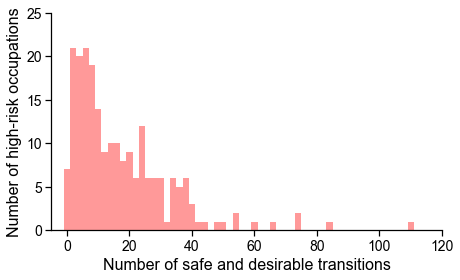

In [41]:
plt.figure(figsize=(7,4))
ax = sns.distplot(occ_high.n_safe_desirable_strict,
                  bins=list(range(-1,140,2)),
                  kde=False,
                  color='r')
plt.ylabel('Number of high-risk occupations', fontsize=16)
plt.xlabel('Number of safe and desirable transitions', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks([0, 5, 10, 15, 20, 25], fontsize=14)
plt.ylim([0, 25])
plt.xlim([-5, 120])
plot_utils.remove_right_axis(ax)
if produce_plots: plot_utils.export_figure('fig_38')
plt.show()


In [42]:
occ_high.n_safe_desirable_strict.mean()

16.677419354838708

In [43]:
occ_high.n_safe_desirable_strict.median()

12.0

In [44]:
# Number of transitions from high-risk occupations for ISCO occupational groups
df = data.add_field_to_occupation(occ_high, field_name='isco_level_1').groupby('isco_level_1').agg({
    'id': 'count',
    'n_safe_desirable_strict': 'mean'
}).sort_values('n_safe_desirable_strict', ascending=False).round(2).reset_index().rename(columns={'id': 'number_of_occupations'})
df = df.merge(data.isco_titles, left_on='isco_level_1', right_on='isco').drop(['isco', 'level'], axis=1)
df = df[['isco_title', 'isco_level_1', 'number_of_occupations', 'n_safe_desirable_strict']]
df

isco_title  isco_level_1  \
0                                     Managers             1   
1                                Professionals             2   
2      Technicians and associate professionals             3   
3                    Service and sales workers             5   
4                     Clerical support workers             4   
5                       Elementary occupations             9   
6  Plant and machine operators, and assemblers             8   

   number_of_occupations  n_safe_desirable_strict  
0                     19                    29.58  
1                     72                    19.75  
2                     48                    19.48  
3                     21                    13.24  
4                     50                     7.98  
5                      5                     4.00  
6                      2                     1.50

### Skills-based sectors

In [45]:
# Calculate the average number of safe and desirable transitions for each skills-based sector
counts_level_1 = occ_high.groupby('skills_based_sector').agg({
    'id': 'count',
    'n_safe_desirable_strict': 'mean',
    'n_safe_desirable_strict_and_highly_viable': 'mean'
}).reset_index().sort_values('n_safe_desirable_strict', ascending=False)
counts_level_1['n_min_viable'] = counts_level_1['n_safe_desirable_strict'] - counts_level_1['n_safe_desirable_strict_and_highly_viable']
df_viz = counts_level_1[counts_level_1.id >= 5]
df_viz

skills_based_sector  id  \
12  technicians, construction, transport & securit...   7   
4                             engineers & researchers   9   
3                                   education workers   5   
11                                     social workers  11   
7                                         ict workers  23   
2                   business & administration workers  87   
10                           sales & services workers  48   
1                                arts & media workers  15   

    n_safe_desirable_strict  n_safe_desirable_strict_and_highly_viable  \
12                27.428571                                   6.142857   
4                 27.222222                                  11.222222   
3                 25.200000                                   8.600000   
11                21.909091                                   3.181818   
7                 19.173913                                   4.434783   
2                 17.425287                                   2.735632   
10                11.208333                                   1.770833   
1                  7.066667                                   2.066667   

    n_min_viable  
12     21.285714  
4      16.000000  
3      16.600000  
11     18.727273  
7      14.739130  
2      14.689655  
10      9.437500  
1       5.000000

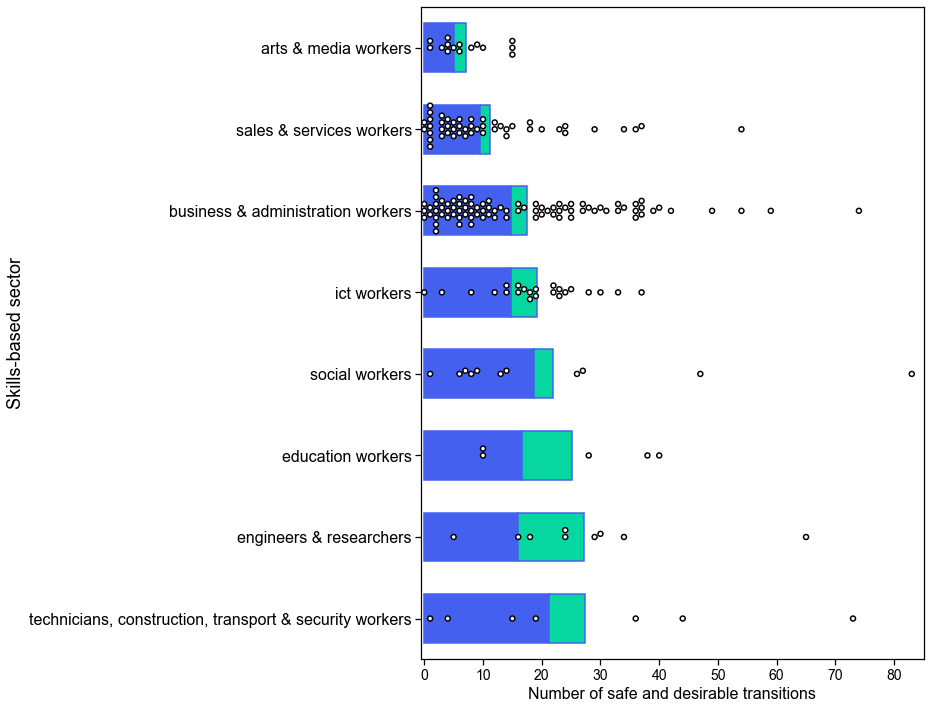

In [46]:
fig, ax0 = plt.subplots(figsize=(9,12))

bottom_bar = df_viz['n_min_viable'].to_list()
top_bar = df_viz['n_safe_desirable_strict_and_highly_viable'].to_list()
ind = np.flip(np.arange(len(df_viz))) # the x locations for the groups
width = 0.6 # the width of the bars

p1 = plt.barh(ind, bottom_bar, width, color='#4361ee', edgecolor='#4361ee', linewidth=1.5)
p2 = plt.barh(ind, top_bar, width, left=bottom_bar, color='#06d6a0',edgecolor='#4361ee', linewidth=1.5)

sns.swarmplot(data=occ_high,
              y='skills_based_sector',
              x="n_safe_desirable_strict",
              order=np.flip(df_viz.skills_based_sector.to_list()),
              edgecolor=[0,0,0],
              color=[1,1,1],
              linewidth=1.5, alpha=1)
plt.xlim([-0.5,85])
plt.ylabel('Skills-based sector', fontsize=18)
plt.xlabel('Number of safe and desirable transitions', fontsize=16)
plt.yticks(ind, df_viz.skills_based_sector.to_list(), fontsize=16)
plt.xticks(fontsize=14)
if produce_plots: plot_utils.export_figure('fig_39')
plt.show()

### Level of training (job zones)

In [47]:
df = occ_high.copy().merge(data.occ[['id', 'job_zone', 'education_level', 'related_work_experience', 'on_the_job_training']])


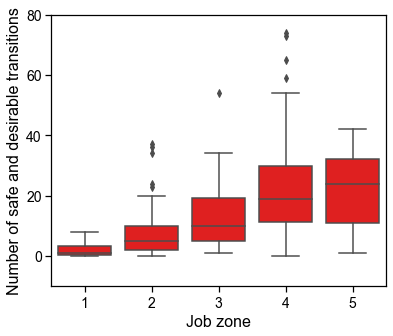

In [48]:
plt.figure(figsize=(6,5))
ax = sns.boxplot(
    data=df,
    y='n_safe_desirable_strict',
    x='job_zone',
    color='r')
plt.yticks(list(range(0,81,20)), fontsize=14)
plt.xticks(list(range(0,5)), [str(x+1) for x in range(5)], fontsize=14)
plt.xlabel('Job zone', fontsize=16)
plt.ylim([-10, 80])
plt.ylabel('Number of safe and desirable transitions', fontsize=16)
if produce_plots: plot_utils.export_figure('fig_42')
plt.show()    


In [49]:
spearmanr(df.n_safe_desirable_strict, df.job_zone)

SpearmanrResult(correlation=0.5192470020673045, pvalue=2.219448759167449e-16)

### Differences between job zones

In [50]:
for job_zone in [1,2,3,4]:
    print(f'Median number of transitions for occupations in job zone {job_zone}: {df[df.job_zone==job_zone].n_safe_desirable_strict.median()}')
    

Median number of transitions for occupations in job zone 1: 1.0
Median number of transitions for occupations in job zone 2: 5.0
Median number of transitions for occupations in job zone 3: 10.0
Median number of transitions for occupations in job zone 4: 19.0


In [51]:
check_dif(2,3)

KruskalResult(statistic=11.531215662371572, pvalue=0.0006843724715227041)

In [52]:
check_dif(2,4)

KruskalResult(statistic=45.4880621971077, pvalue=1.5357198585608913e-11)

In [53]:
check_dif(3,4)

KruskalResult(statistic=11.942214668142622, pvalue=0.0005487620908477735)

In [54]:
check_dif(4,5)

KruskalResult(statistic=0.13017504106297687, pvalue=0.718250619366569)

In [55]:
# Interactive plot for checking outliers
px.scatter(df, y='n_safe_desirable_strict', x='job_zone', hover_data=['id', 'preferred_label'])

### Level of training (other variables)

In [56]:
for field in ['education_level', 'on_the_job_training', 'related_work_experience']:
    print(f'{field} vs. n_safe_desirable_strict')
    print(test_corr(df, field, 'n_safe_desirable_strict'))
    print('---')

education_level vs. n_safe_desirable_strict
SpearmanrResult(correlation=0.5163592233808193, pvalue=3.462263423098748e-16)
---
on_the_job_training vs. n_safe_desirable_strict
SpearmanrResult(correlation=0.40917198665593707, pvalue=3.627130466419579e-10)
---
related_work_experience vs. n_safe_desirable_strict
SpearmanrResult(correlation=0.4588690200164264, pvalue=1.0667935971786802e-12)
---


# 4. Assessment of potential impacts from COVID-19


## 4.1 Feature 1: Impact across skills-based sectors and sub-sectors

In [57]:
# Add 'exposure_score' to the transitions dataframe
df = occ_high.merge(data.occ[['id', 'exposure_score']])

# Aggregate at the level of skills-based sectors
covid_level_1 = df.groupby('skills_based_sector').agg(
    {
        'id': 'count',
        'exposure_score': 'mean',
    }).reset_index().sort_values('exposure_score', ascending=True).rename(columns={'id': 'counts'})
df_viz = covid_level_1[covid_level_1.counts>=5]
df_viz

skills_based_sector  counts  exposure_score
7                                         ict workers      23        0.342656
3                                   education workers       5        0.355530
2                   business & administration workers      87        0.387785
4                             engineers & researchers       9        0.403130
1                                arts & media workers      15        0.453212
11                                     social workers      11        0.507128
12  technicians, construction, transport & securit...       7        0.527835
10                           sales & services workers      48        0.552422

In [58]:
# Mean exposure score
mean_exposure_score = df.exposure_score.mean()
print(mean_exposure_score)

0.44429418372978113


In [59]:
# Median score
df.exposure_score.median()

0.4291464394382177

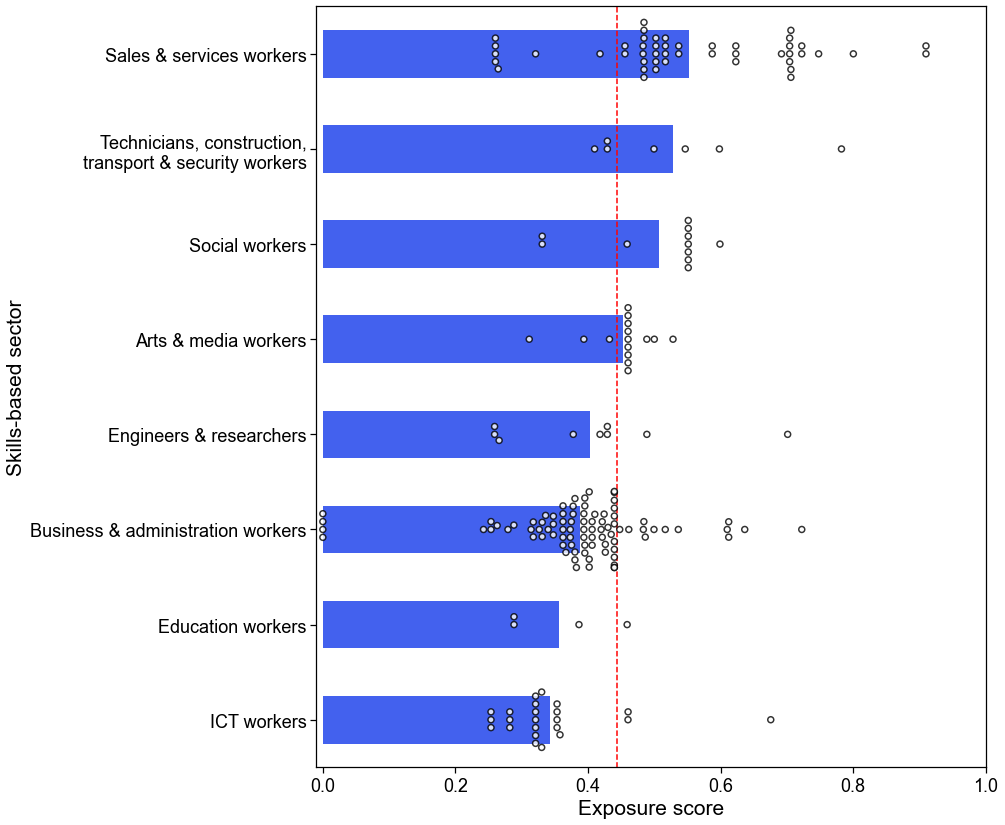

In [60]:
fig, ax0 = plt.subplots(figsize=(12,14))

bottom_bars = df_viz['exposure_score'].to_list()
ind = np.flip(np.arange(len(df_viz)))    
width = 0.5       

p1 = plt.barh(ind, bottom_bars, width, color='#4361ee')

sns.swarmplot(data=df,
              y='skills_based_sector',
              x="exposure_score",
              order=np.flip(df_viz.skills_based_sector.to_list()),
              edgecolor=[0,0,0],
              color=[1,1,1],
              linewidth=1.5, alpha=0.8, size=6)

plt.plot([mean_exposure_score, mean_exposure_score], [-1, 8], 'r', linestyle='dashed')

# Adjust labels
label_list = df_viz.skills_based_sector.to_list()
label_list[-2] = 'technicians, construction,\ntransport & security workers'
for j in range(len(label_list)):
    label_list[j] = label_list[j].capitalize() 
label_list[0] = 'ICT workers'    

plt.xlim([-0.01,1])
plt.ylabel('Skills-based sector', fontsize=21)
plt.xlabel('Exposure score', fontsize=21)
plt.yticks(ind, label_list, fontsize=18)
plt.xticks(fontsize=18)
if produce_plots: plot_utils.export_figure('fig_40')
plt.show()


### Sub-sectors of sales & services occupations

In [61]:
df_sales = df[df.level_1==2].copy()
df_sales.sub_sector = df_sales.sub_sector.apply(lambda x: x.capitalize())

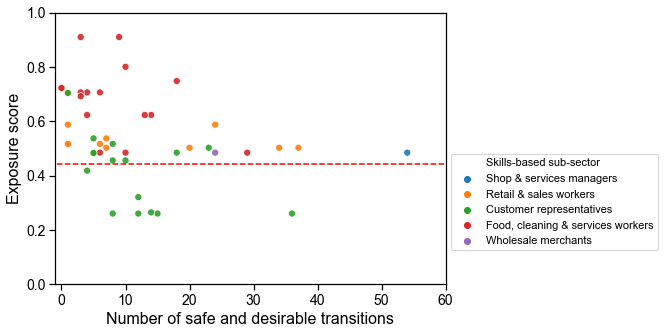

In [62]:
fig, ax0 = plt.subplots(figsize=(7,5))

df_sales.rename(columns={
    'exposure_score': 'Exposure score',
    'sub_sector': 'Skills-based sub-sector',
    'n_safe_desirable_strict': 'Number of safe and desirable transitions'}, inplace=True)

sns.scatterplot(data=df_sales,
                x=df_sales['Number of safe and desirable transitions'],
                y=df_sales['Exposure score'],
                hue='Skills-based sub-sector',
                s=50, alpha=0.9, edgecolor=[1,1,1])
ax = sns.lineplot([-2, 60], [mean_exposure_score, mean_exposure_score], color='r')
ax.lines[0].set_linestyle("--")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.ylim([0.2, 1])
plt.xlim([-1, 60])
plt.xlabel('Number of safe and desirable transitions', fontsize=16)
plt.ylabel('Exposure score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0,1.01,0.2), fontsize=14)
plot_utils.remove_right_axis(barlist)
    
plt.show()

In [63]:
# Interactive plot for checking
px.scatter(df_sales,
           x='Number of safe and desirable transitions',
           y='Exposure score', color='Skills-based sub-sector', hover_data=['preferred_label'])

In [64]:
# Check occupations with below-median number of safe transition options and above-median exposure to COVID-19 risks
thresh_n = df['n_safe_desirable_strict'].median()
thresh_exposure = df['exposure_score'].median()
df_sales[(df_sales['Number of safe and desirable transitions'] < thresh_n) 
        &(df_sales['Exposure score'] > thresh_exposure)].sort_values(['level_1', 'level_2', 'Number of safe and desirable transitions'])[
    ['id', 'preferred_label', 'Number of safe and desirable transitions', 'Exposure score', 'skills_based_sector', 'Skills-based sub-sector']]

id                     preferred_label  \
118  1689                    tourist animator   
193  2645  amusement and recreation attendant   
27    470                           bookmaker   
38    574                        bingo caller   
129  1779                  cabin crew manager   
167  2248                  ticket sales agent   
212  2889                       gaming dealer   
89   1321                       night auditor   
92   1348    ground steward/ground stewardess   
72   1102                      tour organiser   
135  1858         tourist information officer   
68   1062                  steward/stewardess   
107  1524                               usher   
161  2148        tour operator representative   
199  2706                       tote operator   
7     119        motor vehicles parts advisor   
53    762                     lottery cashier   
130  1781                      casino cashier   
51    733                vehicle rental agent   
152  2059                 door to door seller   
47    688       rental service representative   
34    528                             cashier   
90   1338                       odds compiler   
178  2367                       market vendor   
200  2708                  street food vendor   
154  2078                              hawker   
4      71             promotions demonstrator   
208  2862                    personal shopper   

     Number of safe and desirable transitions  Exposure score  \
118                                         0        0.722409   
193                                         0        0.722409   
27                                          1        0.704154   
38                                          1        0.704154   
129                                         3        0.909762   
167                                         3        0.706018   
212                                         3        0.691836   
89                                          4        0.622941   
92                                          4        0.706018   
72                                          6        0.484399   
135                                         6        0.706018   
68                                          9        0.909762   
107                                        10        0.800223   
161                                        10        0.484399   
199                                         1        0.704154   
7                                           5        0.536856   
53                                          5        0.483046   
130                                         5        0.483046   
51                                          8        0.455733   
152                                         8        0.516720   
47                                         10        0.455733   
34                                          1        0.587367   
90                                          1        0.704154   
178                                         1        0.516720   
200                                         1        0.516720   
154                                         6        0.516720   
4                                           7        0.536856   
208                                         7        0.502363   

          skills_based_sector            Skills-based sub-sector  
118  sales & services workers  Food, cleaning & services workers  
193  sales & services workers  Food, cleaning & services workers  
27   sales & services workers  Food, cleaning & services workers  
38   sales & services workers  Food, cleaning & services workers  
129  sales & services workers  Food, cleaning & services workers  
167  sales & services workers  Food, cleaning & services workers  
212  sales & services workers  Food, cleaning & services workers  
89   sales & services workers  Food, cleaning & services workers  
92   sales & services workers  Food, cleaning & services workers  
72   sales & services workers

## 4.2 Feature 2: Impact on transition destinations

In [65]:
# Select transitions from high risk occupations
trans_high_risk = trans[trans.origin_id.isin(data.occ_report[data.occ_report.risk_category=='High risk'].id.to_list())].copy()
trans_high_risk = trans_high_risk[trans_high_risk.is_strictly_safe_desirable]
# Check if destination has a lower/higher exposure score
# (NB: some occupations don't have an exposure score)
trans_high_risk['less_exposure'] = trans_high_risk['destination_exposure_score'] < trans_high_risk['origin_exposure_score']
trans_high_risk['more_exposure'] = trans_high_risk['destination_exposure_score'] >= trans_high_risk['origin_exposure_score']

# Check transitions only from sales & services 'high risk' occupations
sales_services_id = data.occ_report[data.occ_report.level_1==2].id.to_list()
bus_admin_id = data.occ_report[data.occ_report.level_1==1].id.to_list()

tr_sales_services = trans_high_risk[trans_high_risk.origin_id.isin(sales_services_id)]


In [66]:
# Total number of occupations with an exposure score
tr = tr_sales_services[
    (tr_sales_services.origin_exposure_score.isnull()==False)
    &(tr_sales_services.destination_exposure_score.isnull()==False)
]
len(tr)

480

In [67]:
# Number of occupations
len(tr.origin_id.unique())

42

In [68]:
(tr_sales_services['less_exposure']==True).sum()

240

In [69]:
(tr_sales_services['more_exposure']==True).sum()

240

In [70]:
# Prepare data for a Sankey diagram
tr_2 = tr_sales_services[tr_sales_services.destination_id.isin(sales_services_id) &
                         (tr_sales_services.origin_exposure_score.isnull()==False) &
                         (tr_sales_services.destination_exposure_score.isnull()==False)]
tr_3 = tr_sales_services[tr_sales_services.destination_id.isin(bus_admin_id) &
                         (tr_sales_services.origin_exposure_score.isnull()==False) &
                         (tr_sales_services.destination_exposure_score.isnull()==False)]
tr_4 = tr_sales_services[
    (tr_sales_services.destination_id.isin(sales_services_id)==False) &
    (tr_sales_services.destination_id.isin(bus_admin_id)==False) & 
    (tr_sales_services.origin_exposure_score.isnull()==False)  &
                         (tr_sales_services.destination_exposure_score.isnull()==False)
                        ]

n_0_1 =  len(tr_2)
n_0_2 =  len(tr_3)
n_0_5 =  len(tr_4)

n_1_3 =  len(tr_2[tr_2.less_exposure])
n_1_4 = len(tr_2[tr_2.more_exposure])

n_2_3 =  len(tr_3[tr_3.less_exposure])
n_2_4 = len(tr_3[tr_3.more_exposure])

n_5_3 = len(tr_4[tr_4.less_exposure])
n_5_4 = len(tr_4[tr_4.more_exposure])

In [71]:
n_0_1+n_0_2+n_0_5

480

In [72]:
tr__ = tr_sales_services[
                         (tr_sales_services.origin_exposure_score.isnull()==False) &
                         (tr_sales_services.destination_exposure_score.isnull()==False)]
len(tr__.origin_id.unique())

42

In [73]:
# Fraction of destinations in different sectors
print(n_0_1 / (n_0_1+n_0_2+n_0_5))
print(n_0_2 / (n_0_1+n_0_2+n_0_5))
print(n_0_5 / (n_0_1+n_0_2+n_0_5))

0.6416666666666667
0.2708333333333333
0.0875


In [74]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Sales and services", #1
               "Sales and services", #2
               "Business and administration", #3
               "Smaller impact from COVID-19", #4
               "Same or larger impact from COVID-19", #5
                "Other sectors"], #6
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 0, 1, 1, 2, 2, 5, 5], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [1, 2, 5, 3, 4, 3, 4, 3, 4],
      value = [n_0_1,
               n_0_2, n_0_5,
               n_1_3, n_1_4, n_2_3, n_2_4, n_5_3, n_5_4]
  ))])

fig.update_layout(title_text="", font_size=10)
fig.write_image(useful_paths.codebase_dir + 'reports/figures/svg/fig_45.svg')
fig.show()